# IMDB movie review sentiment classification with RNNs

In this notebook, we'll train a recurrent neural network (RNN) for sentiment classification using **PyTorch**.

First, the needed imports. 

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers import models, trainers, pre_tokenizers, normalizers

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.') 
    device = torch.device('cpu')

Using PyTorch version: 2.9.0+cpu
No GPU found, using CPU instead.


## IMDB data set

Next we'll load the IMDB data set using the [Datasets library from Hugging Face](https://huggingface.co/docs/datasets/index).

The dataset contains 50000 movies reviews from the Internet Movie Database, split into 25000 reviews for training and 25000 reviews for testing. Half of the reviews are positive and half are negative.

In [2]:
slurm_project = os.getenv('SLURM_JOB_ACCOUNT')
data_dir = os.path.join('/scratch', slurm_project, 'data') if slurm_project else './data'
print('data_dir =', data_dir)

train_dataset = load_dataset("imdb", split="train", trust_remote_code=False, cache_dir=data_dir)
test_dataset = load_dataset("imdb", split="test", trust_remote_code=False, cache_dir=data_dir)

data_dir = ./data


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

The data items can be accessed by index, and each item is a dictionary with a 'text' and 'label' field.

In [3]:
train_dataset[2]

{'text': "If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />",
 'label': 0}

Let's do a quick count of the labels in the dataset...

In [4]:
def count_labels(dataset):
    counts={}
    i=0
    for item in dataset:
        label = item['label']
        if label not in counts:
            counts[label] = 1
        else:
            counts[label] += 1
    for key, value in counts.items():
        print(f"label: {key}, count: {value}")

print('train')
count_labels(train_dataset)

print('test')
count_labels(test_dataset)

train
label: 0, count: 12500
label: 1, count: 12500
test
label: 0, count: 12500
label: 1, count: 12500


We see that we have two labels: `0` and `1`, each with 12500 items per dataset split. Label `0` indicates a negative review, and label `1` a positive one.

### Pre-processing

Before we start training, we need to process the data into a more suitable format. The text now consists of text strings of variable length, but a neural network typically needs to have fixed-length vectors containing numbers.

To achieve this we will use the `WordLevel` tokenizer from Hugging Face's [Tokenizers library](https://huggingface.co/docs/tokenizers/index). We will tell it to create a vocabulary of the 10,000 most frequent words, and use the special word `[UNK]` for any other words. These 10,001 words will all be mapped to a specific integer index.

In [5]:
# number of most-frequent words to use
nb_words = 10000

tokenizer = Tokenizer(models.WordLevel(unk_token='[UNK]'))
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
tokenizer.normalizer = normalizers.Sequence([normalizers.NFD(),
                                             normalizers.Lowercase(),
                                             normalizers.StripAccents()])

trainer = trainers.WordLevelTrainer(vocab_size=nb_words, min_frequency=1, special_tokens=['[UNK]'])
tokenizer.train_from_iterator(train_dataset['text'], trainer)

Let's try our tokenizer out with an example sentence. We deliberately also add a nonsense word to see if it correctly maps that to `[UNK]` (which has index 0).

In [6]:
tokenizer.encode("hello, this is a test sentence foobazz").ids

[4793, 2, 14, 9, 5, 2246, 4252, 0]

Finally we create a function that ensures all our vector have the same length of 80 by truncating too long sentences and padding too short ones with 0's.

In [7]:
vec_length = 80

def text_transform(text):
    x = tokenizer.encode(text)
    x.truncate(vec_length)
    x.pad(vec_length)
    return x.ids


We can try the text transformation on a test sentence:

In [8]:
print(text_transform("hello, this is a test sentence"))

[4793, 2, 14, 9, 5, 2246, 4252, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Next, let's apply this by transforming our datasets to represent our texts as 80-length vectors and labels as floating point values.

In [9]:
# Apply the list of transforms to the text
# We also switch around so we have the text first and labels second
def apply_transform(x):
    return {
        'input_ids': text_transform(x['text']),
        'label_id': float(x['label'])
        }

train_dataset_tr = train_dataset.map(apply_transform, remove_columns=['text', 'label']).with_format('torch')
test_dataset_tr = test_dataset.map(apply_transform, remove_columns=['text', 'label']).with_format('torch')

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Let's take a look at one example:

In [10]:
train_dataset_tr[2]

{'input_ids': tensor([  56,   75,    7,  824,  250,   14,  576,    6,   27,   12,    1,  724,
            3,   14,   27,    9,  240,   22,   44, 2920,   26,  742,   68,    0,
           74,   28,   10,   18,   10,   20,   39,  255,  251,    0,   23, 1305,
         4543,   11,   99,   11, 2500,   31,   46,  125,  698, 1381,   26,   11,
          143,   46,  227,  114,    0, 6400,    3,    1,  527,  287,  267,   24,
           68,  183, 8552,   32,  923,   39,  287,   66,   24,   39,  155,   39,
            8,   16,  354, 6121,    2,   22,   11,   91]),
 'label_id': tensor(0.)}

Next we'll create the data loaders with a given batch size.

In [11]:
batch_size = 128

train_loader = DataLoader(dataset=train_dataset_tr, batch_size=batch_size, shuffle=True,
                          drop_last=True)
test_loader = DataLoader(dataset=test_dataset_tr, batch_size=batch_size, shuffle=False,
                         drop_last=True)

## RNN model

Let's create an RNN model that contains an LSTM layer. The first layer in the network is an *embedding* layer that converts integer indices to dense vectors of length `embedding_dims`. The output layer contains a single neuron and *sigmoid* non-linearity to match the binary groundtruth (0=negative, 1=positive review). 

All the [neural network building blocks defined in PyTorch can be found in the torch.nn documentation](https://pytorch.org/docs/stable/nn.html).

The output of [LSTM in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) is a 3D tensor of the shape batch_size x sequence_length x lstm_units, that is we get the output after each item in the sequence. Here we only want to have the output after the last item (after the whole sentence has been processed). This means we have to do things a bit more manually and cannot use the simple `nn.Sequential` as in previous exercises.

In [12]:
# model parameters:
embedding_dims = 50
lstm_units = 32

class SimpleRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(nb_words, embedding_dims)
        self.dropout = nn.Dropout(0.2)
        self.lstm = nn.LSTM(embedding_dims, lstm_units, batch_first=True)
        self.linear = nn.Linear(lstm_units, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.emb(x)
        x = self.dropout(x)
        x, (hn, cn) = self.lstm(x)    # LSTM also returns the values of the internal h_n and c_n parameters
        x = self.linear(x[:, -1, :])  # we pick only the last output after having processed the whole sequence
        return self.sigmoid(x.view(-1))

model = SimpleRNN().to(device)
print(model)

SimpleRNN(
  (emb): Embedding(10000, 50)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(50, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## Learning

Now let's train the RNN model. Note that LSTMs are rather slow to train.

In [13]:
def correct(output, target):
    sentiment_pred = output.round().int()          # set to 0 for <0.5 and 1 for >0.5
    correct_ones = sentiment_pred == target.int()  # 1 for correct, 0 for incorrect
    return correct_ones.sum().item()               # count number of correct ones


In [14]:
def train(data_loader, model, criterion, optimizer):
    model.train()

    num_batches = 0
    num_items = 0

    total_loss = 0
    total_correct = 0
    for item in tqdm(data_loader):
        # Copy data and targets to GPU
        data = item['input_ids'].to(device)
        target = item['label_id'].to(device)
        
        # Do a forward pass
        output = model(data)
      
        # Calculate the loss
        loss = criterion(output, target)
        total_loss += loss
        num_batches += 1
        
        # Count number of correct digits
        total_correct += correct(output, target)
        num_items += len(target)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss/num_batches
    accuracy = total_correct/num_items
    print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")
    return train_loss.item(), accuracy


We use the [binary cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) and [RMSprop optimizer](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop).

In [15]:
criterion = nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters())

In [16]:
%%time

losses = []
accuracies = []
epochs = 5
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    loss, acc = train(train_loader, model, criterion, optimizer)
    losses.append(loss)
    accuracies.append(acc)

Training epoch: 1


100%|██████████| 195/195 [00:22<00:00,  8.86it/s]


Average loss: 0.676328, accuracy: 56.48%
Training epoch: 2


100%|██████████| 195/195 [00:26<00:00,  7.45it/s]


Average loss: 0.564313, accuracy: 71.55%
Training epoch: 3


100%|██████████| 195/195 [00:23<00:00,  8.34it/s]


Average loss: 0.484563, accuracy: 77.37%
Training epoch: 4


100%|██████████| 195/195 [00:21<00:00,  8.92it/s]


Average loss: 0.436888, accuracy: 80.39%
Training epoch: 5


100%|██████████| 195/195 [00:26<00:00,  7.49it/s]

Average loss: 0.402296, accuracy: 82.35%
CPU times: total: 5min
Wall time: 1min 59s


Let's plot how the loss and accuracy change over the epochs

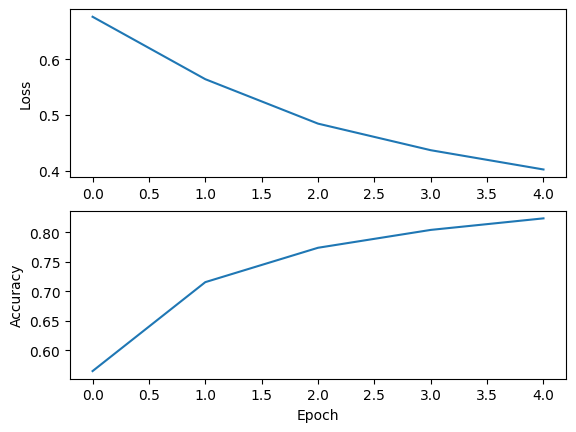

In [17]:
plt.subplot(2,1,1)
plt.plot(losses)
plt.ylabel("Loss")
plt.subplot(2,1,2)
plt.plot(accuracies)
plt.ylabel("Accuracy")
plt.xlabel("Epoch");

### Inference

Here we have the same `test` function as before.

In [18]:
def test(test_loader, model, criterion):
    model.eval()

    num_batches = 0
    num_items = 0

    test_loss = 0
    total_correct = 0

    with torch.no_grad():
        for item in test_loader:
            # Copy data and targets to GPU
            data = item['input_ids'].to(device)
            target = item['label_id'].to(device)

            # Do a forward pass
            output = model(data)
        
            # Calculate the loss
            loss = criterion(output, target)
            test_loss += loss.item()
            num_batches += 1
        
            # Count number of correct digits
            total_correct += correct(output, target)
            num_items += len(target)

    test_loss = test_loss/num_batches
    accuracy = total_correct/num_items

    print(f"Testset accuracy: {100*accuracy:>0.1f}%, average loss: {test_loss:>7f}")
    return test_loss, accuracy

In [19]:
test_loss, test_acc = test(test_loader, model, criterion)

Testset accuracy: 75.7%, average loss: 0.512356


Let's see how the loss and accuracy differ in the training and test sets:

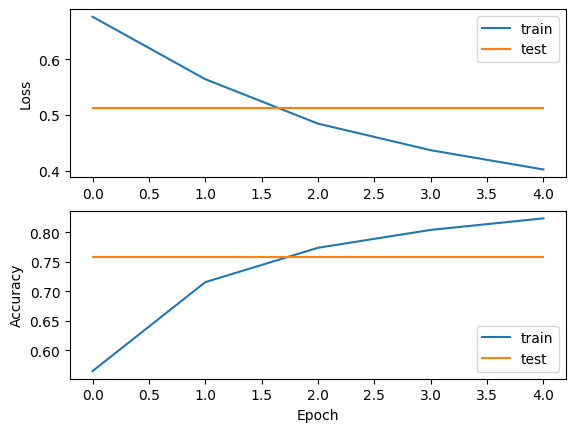

In [20]:
plt.subplot(2,1,1)
plt.plot(losses, label='train')
plt.plot([0,epochs-1], [test_loss, test_loss], label='test')
plt.ylabel("Loss")
plt.legend()

plt.subplot(2,1,2)
plt.plot(accuracies, label='train')
plt.plot([0,epochs-1], [test_acc, test_acc], label='test')
plt.ylabel("Accuracy")
plt.legend()
plt.xlabel("Epoch");

We can also use the learned model to predict sentiments for new reviews:

In [21]:
#myreviewtext = 'this movie was the worst i have ever seen and the actors were horrible'
myreviewtext = 'this movie was awesome and had the best action scenes I have ever seen'

input = torch.tensor(text_transform(myreviewtext)).view(1, -1).to(device)
print(input)
p = model(input).item()
sentiment = "POSITIVE" if p > 0.5 else "NEGATIVE"
print(f'Predicted sentiment: {sentiment} ({p:.4f})')

tensor([[  14,   25,   21, 1226,    4,   79,    1,  133,  224,  156,   13,   37,
          141,  124,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
Predicted sentiment: POSITIVE (0.8592)


## Task 1: Two LSTM layers

Create a model with two LSTM layers (hint: there is a `num_layers` option!). Optionally, you can also use bidirectional layers (set `bidirectional=True` in LSTM). See the [LSTM documentation in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM).

You can consult the [PyTorch documentation](https://pytorch.org/docs/stable/index.html), in particular all the [neural network building blocks can be found in the `torch.nn` documentation](https://pytorch.org/docs/stable/nn.html).

The code below is missing the model definition. You can copy any suitable layers from the example above.

In [23]:
class TwoLayeredRNN(nn.Module):
    def __init__(self):
        super().__init__()
        # TASK 1: ADD LAYERS HERE
        self.emb = nn.Embedding(nb_words, embedding_dims)
        self.dropout = nn.Dropout(0.25)
        self.lstm = nn.LSTM(embedding_dims, lstm_units, num_layers=2,
                    batch_first=True, bidirectional=True, dropout=0.25)
        self.linear = nn.Linear(lstm_units*2, 1)

        # With bidirectional
        #self.lstm = nn.LSTM(embedding_dims, lstm_units, num_layers=2,
        #                    batch_first=True, bidirectional=True)
        #self.linear = nn.Linear(lstm_units*2, 1)
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.emb(x)
        x = self.dropout(x)
        x, (hn, cn) = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return self.sigmoid(x.view(-1))


If you want to see an example answer, change the type of the cell below to "Code" in the menu bar above and then execute the cell. Execute the cell again to run the example code.

**Note:** in Google Colab you can [click here](https://github.com/csc-training/intro-to-dl/blob/master/day1/solutions/pytorch-imdb-rnn-example-answer.py) and copy the answer manually

In [24]:
ex1_model = TwoLayeredRNN()
print(ex1_model)

assert len(list(ex1_model.parameters())) > 0, "ERROR: You need to write the missing model definition above!"


ex1_model = ex1_model.to(device)

TwoLayeredRNN(
  (emb): Embedding(10000, 50)
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(50, 32, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [25]:
ex1_criterion = nn.BCELoss()
ex1_optimizer = torch.optim.RMSprop(ex1_model.parameters())

In [26]:
%%time

losses = []
accuracies = []
epochs = 5
for epoch in range(epochs):
    print(f"Epoch: {epoch+1} ...")
    loss, acc = train(train_loader, ex1_model, ex1_criterion, ex1_optimizer)
    losses.append(loss)
    accuracies.append(acc)

Epoch: 1 ...


100%|██████████| 195/195 [01:17<00:00,  2.52it/s]


Average loss: 0.690195, accuracy: 53.33%
Epoch: 2 ...


100%|██████████| 195/195 [01:26<00:00,  2.27it/s]


Average loss: 0.593859, accuracy: 67.82%
Epoch: 3 ...


100%|██████████| 195/195 [01:32<00:00,  2.10it/s]


Average loss: 0.454563, accuracy: 79.00%
Epoch: 4 ...


100%|██████████| 195/195 [02:14<00:00,  1.45it/s]


Average loss: 0.386988, accuracy: 82.92%
Epoch: 5 ...


100%|██████████| 195/195 [02:44<00:00,  1.18it/s]

Average loss: 0.344837, accuracy: 85.00%
CPU times: total: 22min 59s
Wall time: 9min 16s


In [27]:
ex1_test_loss, ex1_test_acc = test(test_loader, ex1_model, ex1_criterion)

Testset accuracy: 79.3%, average loss: 0.446546


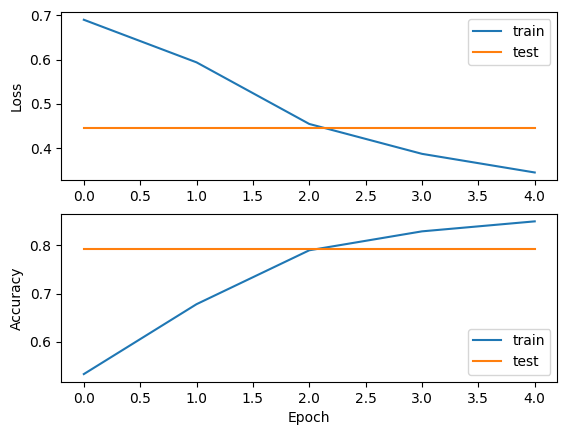

In [28]:
plt.subplot(2,1,1)
plt.plot(losses, label='train')
plt.plot([0,epochs-1], [ex1_test_loss, ex1_test_loss], label='test')
plt.ylabel("Loss")
plt.legend()

plt.subplot(2,1,2)
plt.plot(accuracies, label='train')
plt.plot([0,epochs-1], [ex1_test_acc, ex1_test_acc], label='test')
plt.ylabel("Accuracy")
plt.legend()
plt.xlabel("Epoch");

## Task 2: Model tuning

Modify the model further.  Try to improve the classification accuracy on the test set, or experiment with the effects of different parameters.

To combat overfitting, you can try for example to add dropout. For [LSTMs](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM), dropout between the LSTM layers can be set with the `dropout` parameter:

    self.lstm = nn.LSTM(embedding_dims, lstm_units, num_layers=2,
                        batch_first=True, dropout=0.2)


If you wish to change the batch size, you need to re-define the data loaders.

## Extra: View model summary

One way to view more information about the model is to use an external package such as [Torchinfo](https://github.com/TylerYep/torchinfo). It is not installed in the standard Pytorch module in LUMI, so you need to install it using pip:

In [29]:
from torchinfo import summary

In [30]:
summary(model, input_size=(batch_size, vec_length), dtypes=[torch.long],
        col_names=["input_size", "output_size", "kernel_size", "num_params"], verbose=2);

Layer (type:depth-idx)                   Input Shape               Output Shape              Kernel Shape              Param #
SimpleRNN                                [128, 80]                 [128]                     --                        --
├─Embedding: 1-1                         [128, 80]                 [128, 80, 50]             --                        500,000
│    └─weight                                                                                [50, 10000]               └─500,000
├─Dropout: 1-2                           [128, 80, 50]             [128, 80, 50]             --                        --
├─LSTM: 1-3                              [128, 80, 50]             [128, 80, 32]             --                        10,752
│    └─weight_ih_l0                                                                          [128, 50]                 ├─6,400
│    └─weight_hh_l0                                                                          [128, 32]                 ├